# Neural Network classification with PyTorch

### 1. Make classification data and get it ready

In [8]:
import sklearn

In [9]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples,
                   noise=0.03, # To add little bit of randomness
                   random_state=42) # Equivalent to random seed

In [10]:
len(X), len(y)

(1000, 1000)

In [11]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [12]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})


In [13]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


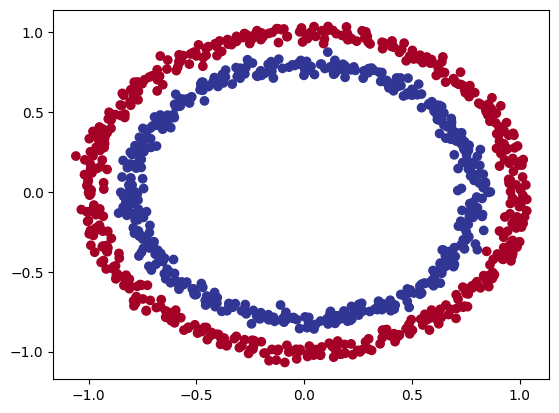

In [14]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

#### 1.1 Check input and output shapes

In [15]:
X.shape, y.shape

((1000, 2), (1000,))

#### 1.2 Turn data into tensors and create train and test splits

In [16]:
import torch
torch.__version__

'2.5.1+cu124'

In [17]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [18]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [19]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [20]:
type(X), X.dtype, type(y), y.dtype

(torch.Tensor, torch.float32, torch.Tensor, torch.float32)

In [21]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [22]:
len(X_train), len(X_test), len(y_train), len(y_test), n_samples

(800, 200, 800, 200, 1000)

### 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop


In [23]:
# Import torch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

No we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [25]:
from sklearn import datasets
# 1. Construct a model that subclassess nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (same shape as X) and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
device

'cpu'

In [27]:
next(model_0.parameters()).device

device(type='cpu')

In [28]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
model_0.state_dict() # We will get weight and bias values for both the layers separately

OrderedDict([('0.weight',
              tensor([[-0.3496,  0.0040],
                      [-0.4453, -0.0283],
                      [ 0.1051,  0.1261],
                      [ 0.0471, -0.1660],
                      [ 0.3567,  0.5540]])),
             ('0.bias', tensor([ 0.0166, -0.2139,  0.5479,  0.5688,  0.5597])),
             ('1.weight',
              tensor([[ 0.2217,  0.1456,  0.2261,  0.2962, -0.0054]])),
             ('1.bias', tensor([0.2534]))])

In [30]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

In [31]:
untrained_preds.shape, X_test.shape

(torch.Size([200, 1]), torch.Size([200, 2]))

In [32]:
len(untrained_preds), len(X_test)

(200, 200)

#### 2.1 Setup Loss Function and Optimizer

In [33]:
# Setup the loss function

# loss_fn = nn.BCELoss() # Here, requires to have gone through the sigmoid activation function prior to input to BCELOss
# loss_fn = nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )

# This is numerically stable than above method
loss_fn = nn.BCEWithLogitsLoss() # This has sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [34]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### 3. Train model

To train our model, we're going to need to build a training loop with following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

#### 3.1 Going from raw logits -> prediction probabilites -> prediction labels

Our model outputs are going to be raw **logits**. The `logits` are the raw outputs of our model without being passed to any activation function.

We can convert these logits into **prediction probabilites** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then, we can convert our model's prediction probabilites to **prediction labels** by either rounding them or taking the `argmax()`

In [35]:
# View first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5369],
        [0.4878],
        [0.5986],
        [0.5197],
        [0.4923]])

In [36]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [37]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6311],
        [0.6196],
        [0.6453],
        [0.6271],
        [0.6207]])

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >=0.5, y=1 (class 1)
* `y_pred_probs` <0.5, y=0 (class 0)

In [38]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze(), y_pred_labels.squeeze()

tensor([True, True, True, True, True])


(tensor([1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>))

#### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42) # For CUDA devices

# Set the number of epochs
epochs = 100

# Put data to target deice
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate the loss/accuracy

    ### Since BCEWithLogitsLoss() has sigmoid fnction built in, while calculating loss, we provide y_logits instead of y_pred
    loss = loss_fn(y_logits,
                   y_train)

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        # 3. Print out whats' happenin'
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70778, Acc: 50.50% | Test loss: 0.72240, Test acc: 45.50%
Epoch: 10 | Loss: 0.70375, Acc: 50.88% | Test loss: 0.71680, Test acc: 45.50%
Epoch: 20 | Loss: 0.70132, Acc: 51.00% | Test loss: 0.71288, Test acc: 46.50%
Epoch: 30 | Loss: 0.69966, Acc: 51.25% | Test loss: 0.70993, Test acc: 46.50%
Epoch: 40 | Loss: 0.69845, Acc: 51.12% | Test loss: 0.70765, Test acc: 46.50%
Epoch: 50 | Loss: 0.69755, Acc: 50.75% | Test loss: 0.70584, Test acc: 48.50%
Epoch: 60 | Loss: 0.69686, Acc: 50.75% | Test loss: 0.70439, Test acc: 49.00%
Epoch: 70 | Loss: 0.69631, Acc: 50.88% | Test loss: 0.70321, Test acc: 49.00%
Epoch: 80 | Loss: 0.69588, Acc: 50.25% | Test loss: 0.70223, Test acc: 48.00%
Epoch: 90 | Loss: 0.69553, Acc: 50.62% | Test loss: 0.70142, Test acc: 48.00%


### 4. Make predictions and evaluate the model

From the above metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper_functions.py')
    # Get raw version
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py','wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

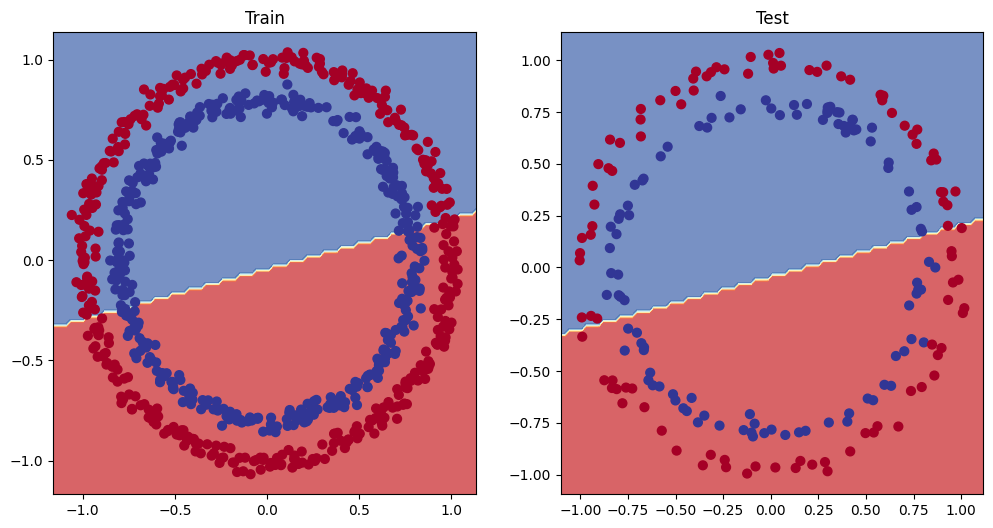

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

### 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (Epoch increase)
* Changing/ Adding the activation functions
* Change the learning rate
* Change the loss function
* Change the optimization function
* Training the model for longer/Fitting for longer

These options are all from a model's perspective because they deal directly with the model, rather than the data.

In [ ]:
# Create a model
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediciton probabilities -> prediction labels

    # Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()


    ### Testing
    model_1.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)


    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} , Train Acc: {acc:.2f}% | Test Loss: {test_loss:5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69396 , Train Acc: 50.88% | Test Loss: 0.692615, Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69305 , Train Acc: 50.38% | Test Loss: 0.693790, Test Acc: 48.00%
Epoch: 200 | Train Loss: 0.69299 , Train Acc: 51.12% | Test Loss: 0.694373, Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.69298 , Train Acc: 51.62% | Test Loss: 0.694577, Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.69298 , Train Acc: 51.12% | Test Loss: 0.694645, Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.69298 , Train Acc: 51.00% | Test Loss: 0.694668, Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.69298 , Train Acc: 51.00% | Test Loss: 0.694676, Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.69298 , Train Acc: 51.00% | Test Loss: 0.694678, Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69298 , Train Acc: 51.00% | Test Loss: 0.694679, Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.69298 , Train Acc: 51.00% | Test Loss: 0.694679, Test Acc: 46.00%


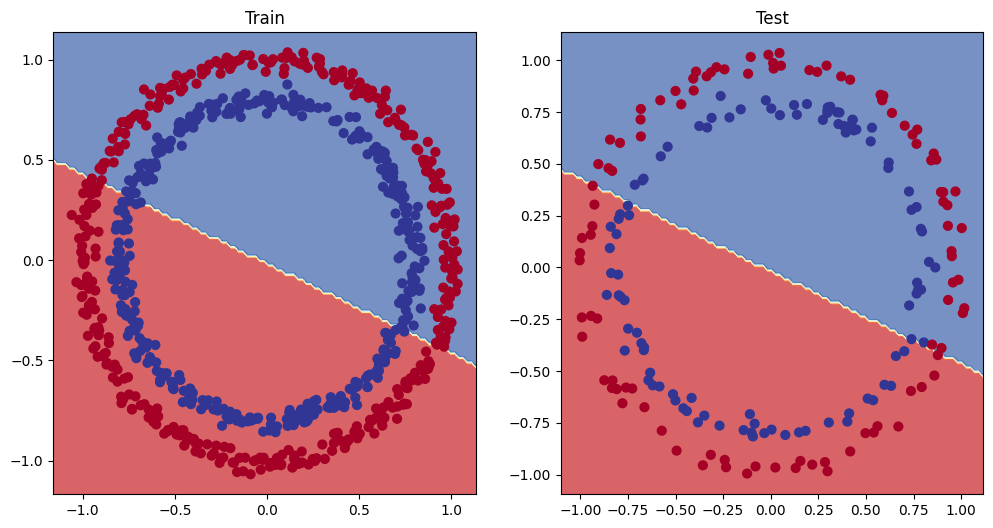

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 6. The missing piece: Non Linearity

In [ ]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Where should we put our non-linear activation function?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


#### Training the model with non-linearity

In [ ]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilites -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()


    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%


In [ ]:
# Make Predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

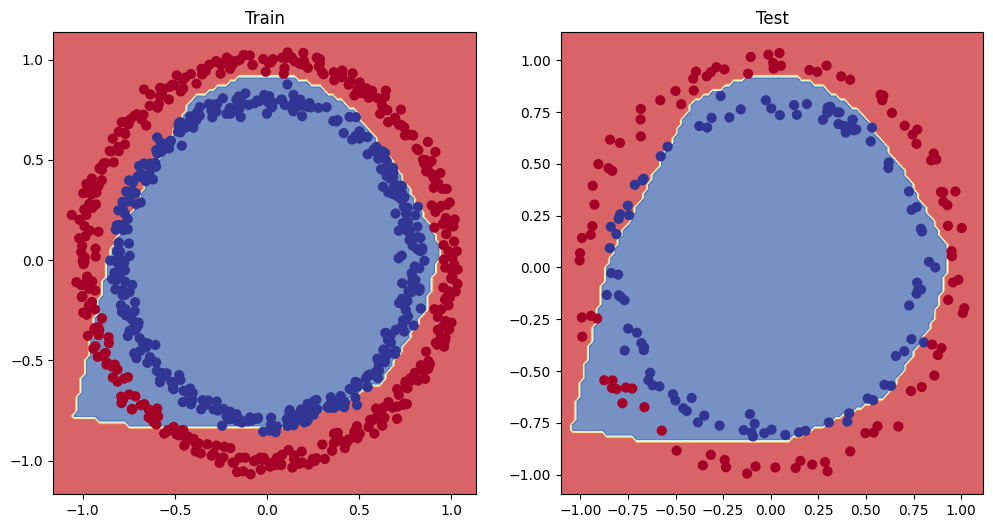

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984])),
             ('layer_2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01,  5.6581e-02,  5.3486e-01, -1.927

### 7. Replicating non-linear ativation functions

Neural Networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

These tools are linear and non-linear functions.

In [ ]:
# Create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)


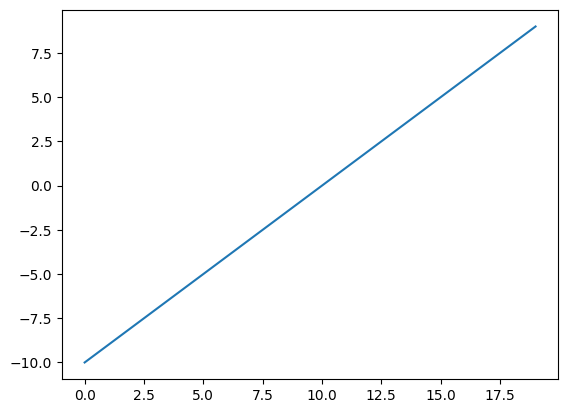

In [ ]:
plt.plot(A);

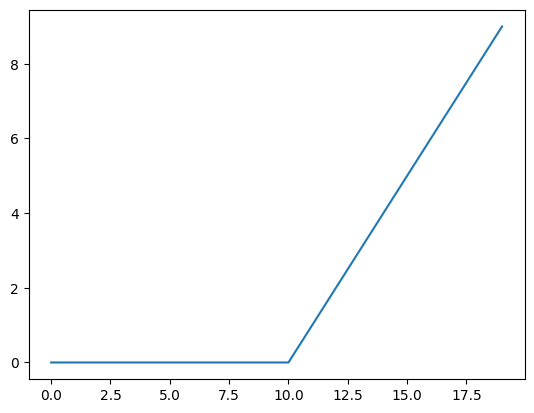

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

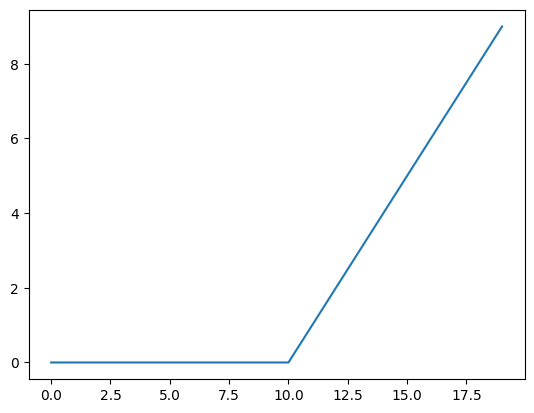

In [ ]:
plt.plot(relu(A))

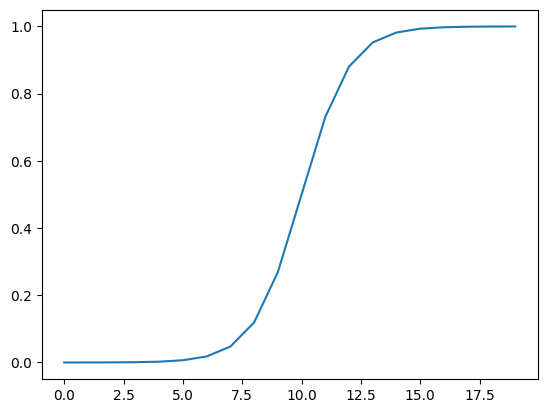

In [ ]:
# Now let's do same for sigmoid
plt.plot(torch.sigmoid(A))

In [ ]:
# Now let's do same for sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

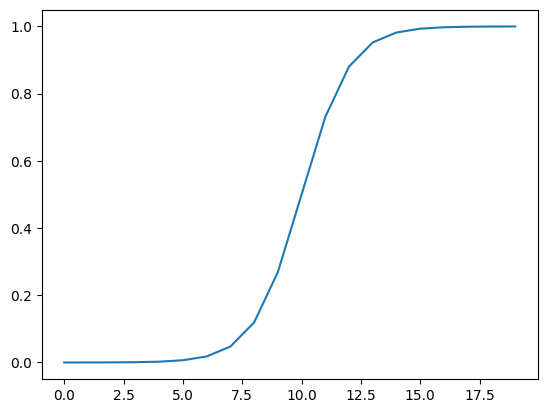

In [ ]:
plt.plot(sigmoid(A))

###  8. Putting it all together with a multi-class classification problem

#### 8.1 Creating a toy multi-class dataset

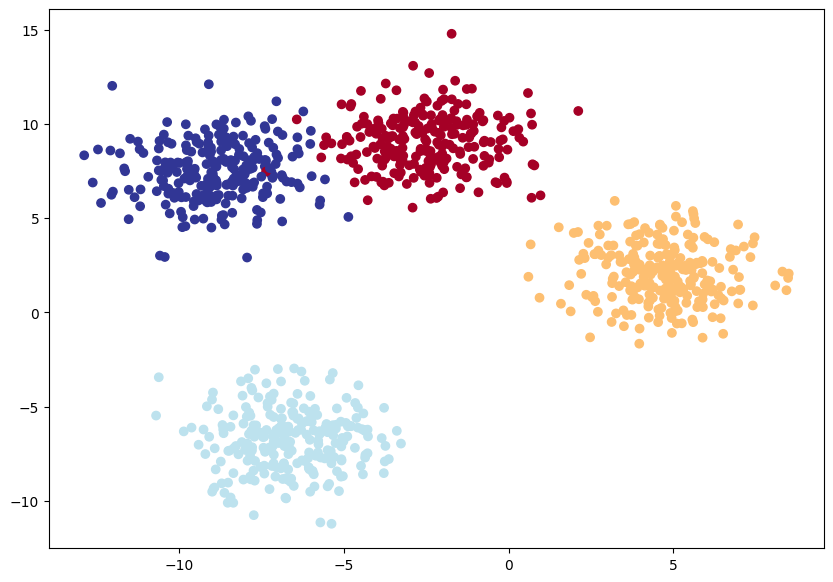

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

#### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default is 8

        Returns:

        Example:

        Raise:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )


    def forward(self, x):
        return self.linear_layer_stack(x)


# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), torch.Size([800]), tensor([1, 0, 2, 2, 0]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

#### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

#### 8.4 Getting predicition probabilities for a multi-class PyTorch model

In [ ]:
next(model_4.parameters()).device, X_blob_test.device

(device(type='cuda', index=0), device(type='cpu'))

In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [ ]:
torch.max(y_pred_probs[57]) # The class which has this probability is the output

tensor(0.3106, device='cuda:0')

In [ ]:
torch.argmax(y_pred_probs[57]) # Predicted class

tensor(1, device='cuda:0')

In [ ]:
# Convert  our model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

#### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through the data
for epoch in range(epochs):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                   y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)

    # Print out what's happenin'
    if epoch % 10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.1588, Acc: 40.38 | Test loss: 1.0755, Test acc: 48.00
Epoch: 10 | Loss: 0.6448, Acc: 96.75 | Test loss: 0.6607, Test acc: 97.50
Epoch: 20 | Loss: 0.4254, Acc: 98.50 | Test loss: 0.4307, Test acc: 100.00
Epoch: 30 | Loss: 0.2529, Acc: 99.12 | Test loss: 0.2451, Test acc: 99.50
Epoch: 40 | Loss: 0.1123, Acc: 99.25 | Test loss: 0.1023, Test acc: 99.50
Epoch: 50 | Loss: 0.0663, Acc: 99.25 | Test loss: 0.0585, Test acc: 99.50
Epoch: 60 | Loss: 0.0507, Acc: 99.25 | Test loss: 0.0429, Test acc: 99.50
Epoch: 70 | Loss: 0.0430, Acc: 99.25 | Test loss: 0.0349, Test acc: 99.50
Epoch: 80 | Loss: 0.0384, Acc: 99.25 | Test loss: 0.0299, Test acc: 99.50
Epoch: 90 | Loss: 0.0352, Acc: 99.25 | Test loss: 0.0266, Test acc: 99.50


#### 8.6 Making and evaluating predictions with a PyTorch multi-class model.

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [ ]:
# Go from logits -> Prediction probabilites
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [ ]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

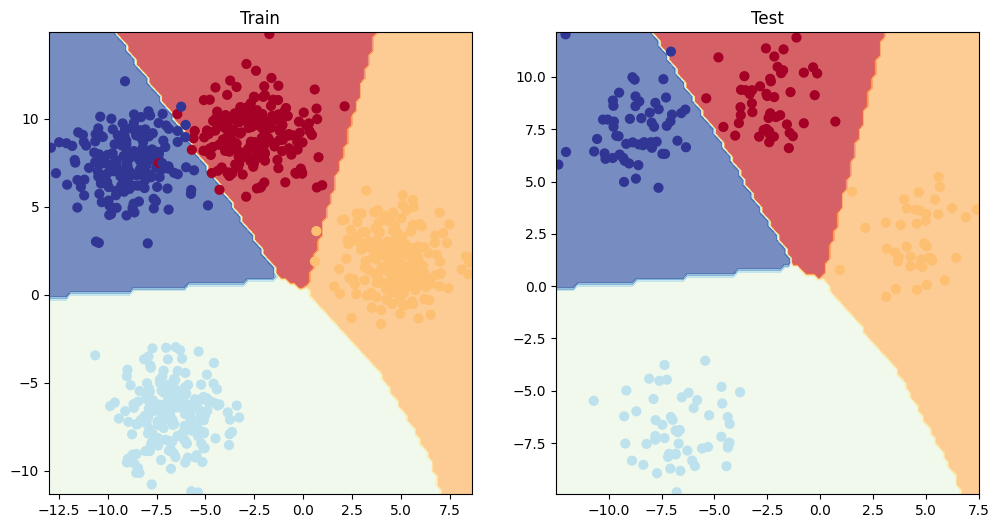

In [ ]:
# Visualize
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy -> Not best for imbalanced datasets
* Precision
* Recall
* F1-Score -> Good overall metric for classification model
* Confusion Matrix
* Classification Report

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

PyTorch Metrics -> https://lightning.ai/docs/torchmetrics/stable/

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')